In [17]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision
import torchvision.models as models
import lightning.pytorch as pl


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [5]:
CFG = {
    'IMG_SIZE':224,
    'SEED':41,
    'NUM_VIEWS' : 2,
    'CHECKPOINT_PATH' : './',
    'NUM_WORKERS' : 0,
    'LR' : 5e-4,
    'HIDDEN_DIM' : 128,
    'BATCH_SIZE' : 64,
    'TEMP' : 0.07,
    'WEIGHT_DECAY' : 1e-4,
    'MAX_EPOCHS' : 500
}

## Fixed RandomSeed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [30]:
type(ContrastiveTransforms(base_transforms= contrast_transforms)

True

In [21]:
all_img_list = glob.glob('train/*/*')
# all_img_list = [f.replace(os.sep, '/') for f in all_img_list]

In [22]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split(os.sep)[-2])

In [13]:
df

,img_path,label
0,train\가구수정\0.png,가구수정
1,train\가구수정\1.png,가구수정
2,train\가구수정\10.png,가구수정
3,train\가구수정\11.png,가구수정
4,train\가구수정\2.png,가구수정
...,...,...
3452,train\훼손\995.png,훼손
3453,train\훼손\996.png,훼손
3454,train\훼손\997.png,훼손
3455,train\훼손\998.png,훼손


In [23]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])

## Label-Encoding

In [24]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

In [75]:
class ContrastiveTransforms :
    def __init__(self, base_transforms, n_views = 2) :
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x) :
        return [self.base_transforms(image = x)['image'] for _ in range(self.n_views)]

In [76]:
## crop and resize, flip, color distort, rotate, gaussian noise, gausian blur
contrast_transforms = A.Compose(
    [
        A.Flip(p = 1),
        A.RandomCropFromBorders(crop_left = 0.1, crop_right = 0.1, crop_top = 0.1, crop_bottom = 0.1, p = 0.9),
        A.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2, p = 0.9),
        A.Resize(height = CFG['IMG_SIZE'], width = CFG['IMG_SIZE']),
        A.GaussianBlur(p = 0.5),
        A.Normalize(),  
        ToTensorV2(),
              
    ]
)
# contrast_transforms = transforms.Compose(
#     [
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomResizedCrop(size=CFG['IMG_SIZE']),
#         transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
#         transforms.RandomGrayscale(p=0.2),
#         transforms.GaussianBlur(kernel_size=9),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,)),
#     ]
# )

In [77]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]

        image = np.array(Image.open(img_path))

        
        if self.transforms is not None:
            if type(self.transforms) == ContrastiveTransforms :
                image = self.transforms(image)
            else :
                image = self.transforms(image = image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [78]:
train_dataset = CustomDataset(train['img_path'].values, label_list = train['label'].values, 
                        transforms = ContrastiveTransforms(base_transforms= contrast_transforms, n_views= CFG['NUM_VIEWS']))
val_dataset = CustomDataset(val['img_path'].values, label_list = val['label'].values, 
                        transforms = ContrastiveTransforms(base_transforms= contrast_transforms, n_views= CFG['NUM_VIEWS']))


In [79]:
train_dataset.__getitem__(0)[0]

[tensor([[[-0.5424, -0.5424, -0.4054,  ..., -0.6965, -0.7308, -0.7308],
          [-0.4568, -0.5424, -0.5253,  ..., -0.6965, -0.7308, -0.7479],
          [-0.3027, -0.4568, -0.5938,  ..., -0.6965, -0.6965, -0.6965],
          ...,
          [-0.6109, -0.5767, -0.5082,  ..., -0.8335, -0.9020, -0.8678],
          [-0.6281, -0.6281, -0.6281,  ..., -0.8507, -0.8849, -0.8678],
          [-0.6281, -0.6623, -0.6965,  ..., -0.8335, -0.8849, -0.8849]],
 
         [[-0.4076, -0.4076, -0.2675,  ..., -0.5826, -0.6001, -0.6001],
          [-0.3375, -0.4251, -0.3901,  ..., -0.5826, -0.6176, -0.6176],
          [-0.1975, -0.3375, -0.4776,  ..., -0.5826, -0.5826, -0.5826],
          ...,
          [-0.4601, -0.4076, -0.3375,  ..., -0.6352, -0.7052, -0.7052],
          [-0.4776, -0.4776, -0.4601,  ..., -0.6527, -0.7052, -0.6877],
          [-0.4601, -0.5126, -0.5476,  ..., -0.6527, -0.7227, -0.7227]],
 
         [[-0.2184, -0.2358, -0.1138,  ..., -0.3578, -0.3753, -0.3753],
          [-0.1312, -0.2358,

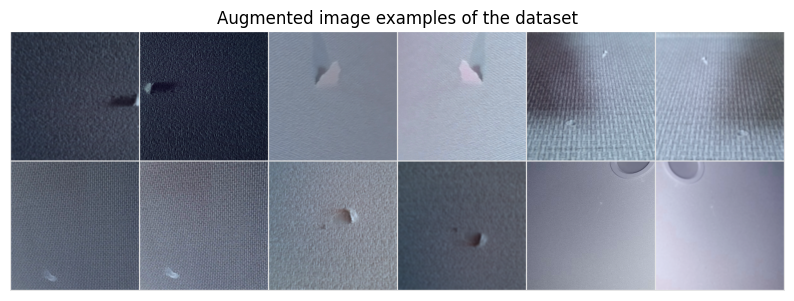

In [80]:
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in train_dataset[idx][0]], dim = 0)
img_grid = torchvision.utils.make_grid(imgs, nrow = 6, normalize = True, pad_value = .9)
img_grid = img_grid.permute(1,2,0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()


In [82]:
train_loader = DataLoader(
            train_dataset,
            batch_size=32,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=CFG['NUM_WORKERS'],
        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


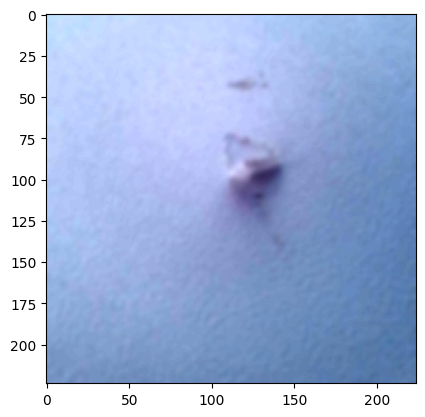

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


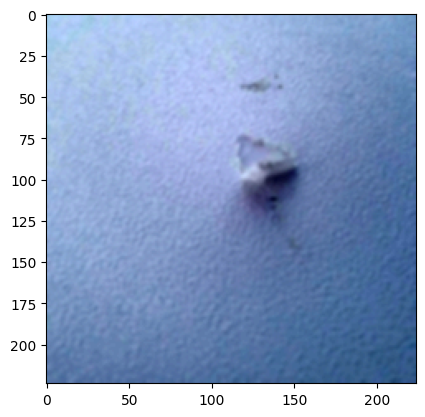

In [103]:
batch = next(iter(train_loader))
imgs, _ = batch
imgs = torch.cat(imgs, dim=0)


class simplemodel(nn.Module) :
    def __init__(self, hidden_dim) :
        super().__init__()
        self.convnet = torchvision.models.resnet18(
                    pretrained=False, num_classes=4 * hidden_dim
                )  # num_classes is the output size of the last linear layer
                # The MLP for g(.) consists of Linear->ReLU->Linear
        self.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim),
        )

    def forward(self, x) :
        x = self.convnet(x)
        x = self.fc(x)
        return x

model = simplemodel(hidden_dim = 128)

feats = model(imgs)

print(feats.shape)

print(feats[:, None, :].shape, feats[None, :, :].shape)
cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
print(cos_sim.shape)

self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
cos_sim.masked_fill_(self_mask, -9e15)
pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
pos_mask
# def info_nce_loss( batch, mode="train"):
#     imgs, _ = batch
#     imgs = torch.cat(imgs, dim=0)

#     # Encode all images
#     feats = self.convnet(imgs)
#     # Calculate cosine similarity
#     cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
#     # Mask out cosine similarity to itself
#     self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
#     cos_sim.masked_fill_(self_mask, -9e15)
#     # Find positive example -> batch_size//2 away from the original example
#     pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
#     # InfoNCE loss
#     cos_sim = cos_sim / self.hparams.temperature
#     nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
#     nll = nll.mean()

#     # Logging loss
#     self.log(mode + "_loss", nll)
#     # Get ranking position of positive example
#     comb_sim = torch.cat(
#         [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
#         dim=-1,
#     )
#     sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
#     # Logging ranking metrics
#     self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
#     self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
#     self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

#     return nll


torch.Size([64, 128])
torch.Size([64, 1, 128]) torch.Size([1, 64, 128])
torch.Size([64, 64])


tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [104]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
output = F.cosine_similarity(input1, input2)
print(output.shape)

torch.Size([100])


In [106]:
class SimCLR(pl.LightningModule):
    def __init__(self,  hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(
            pretrained=False, num_classes=4 * hidden_dim
        )  # num_classes is the output size of the last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim),
        )

    def forward(self, x) :
        x = self.convnet(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode="train"):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)
        # Get ranking position of positive example
        comb_sim = torch.cat(
            [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode="val")

In [107]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CFG['CHECKPOINT_PATH'], "SimCLR"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc_top5"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CFG['CHECKPOINT_PATH'], "SimCLR.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=CFG['NUM_WORKERS'],
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=CFG['NUM_WORKERS'],
        )
        pl.seed_everything(42)  # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

In [69]:
basemodel = models.efficientnet_b0(pretrained=False, num_classes = 4 * CFG['HIDDEN_DIM'])

simclr_model = train_simclr(
                            batch_size= CFG['BATCH_SIZE'], 
                            hidden_dim= CFG['HIDDEN_DIM'], 
                            lr=CFG['LR'], 
                            temperature=CFG['TEMP'], 
                            weight_decay= CFG['WEIGHT_DECAY'], 
                            max_epochs= CFG['MAX_EPOCHS']
                        )




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | convnet | ResNet | 11.5 M
-----------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.019    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [108]:
class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(self.hparams.max_epochs * 0.6), int(self.hparams.max_epochs * 0.8)], gamma=0.1
        )
        return [optimizer], [lr_scheduler]
    
    def forward(self, x) :
        return self.model(x)

    def _calculate_loss(self, batch, mode="train"):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [110]:
img_transforms = A.Compose([A.Resize(width = CFG['IMG_SIZE'], height = CFG['IMG_SIZE']),
                            A.Normalize((0.5,), (0.5)),
                            ToTensorV2() ])

train_img_dataset = CustomDataset(train['img_path'].values, label_list = train['label'].values, 
                        transforms = img_transforms)
test = pd.read_csv('./test.csv')
test_dataset = CustomDataset(test['img_path'].values, None, img_transforms)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)


In [111]:
@torch.no_grad()
def prepare_data_features(model, dataset, infer = False):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = DataLoader(dataset, batch_size=64, num_workers=CFG['NUM_WORKERS'], shuffle=False, drop_last=False)
    feats, labels = [], []
    if infer :
        for batch_imgs in tqdm(data_loader):
            batch_imgs = batch_imgs.to(device)
            batch_feats = network(batch_imgs)
            feats.append(batch_feats.detach().cpu())

        feats = torch.cat(feats, dim=0)
        return TensorDataset(feats)

    else : 

        for batch_imgs, batch_labels in tqdm(data_loader):
            batch_imgs = batch_imgs.to(device)
            batch_feats = network(batch_imgs)
            feats.append(batch_feats.detach().cpu())
            labels.append(batch_labels.type(torch.LongTensor))

        feats = torch.cat(feats, dim=0)
        labels = torch.cat(labels, dim=0)

        # Sort images by labels
        labels, idxs = labels.sort()
        feats = feats[idxs]

        return TensorDataset(feats, labels)

In [141]:
from copy import deepcopy

train_feats_simclr = prepare_data_features(simclr_model, train_img_dataset)


  0%|          | 0/38 [00:00<?, ?it/s]

In [142]:
test_feats_simclr = prepare_data_features(simclr_model, test_img_dataset)

  0%|          | 0/17 [00:00<?, ?it/s]

In [112]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=500, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CFG['CHECKPOINT_PATH'], "LogisticRegression"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=False,
        check_val_every_n_epoch=10,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = DataLoader(
        train_feats_data, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0
    )
    test_loader = DataLoader(
        test_feats_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CFG['CHECKPOINT_PATH'], f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    test_result = trainer.predict(model, dataloaders=test_loader)
    # result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, test_result

In [163]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = TensorDataset(
        *(t.unflatten(0, (10, 500))[:, :num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors)
    )
    return new_dataset

In [164]:
results = {}
# for num_imgs_per_label in [10, 20]:
#     sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
_, small_set_results, test_result = train_logreg(
    batch_size=64,
    train_feats_data=train_feats_simclr, # sub_train_set,
    test_feats_data=test_feats_simclr,
    model_suffix=num_imgs_per_label,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=19,
    lr=1e-3,
    weight_decay=1e-3,
    max_epochs = 800
)
# results[num_imgs_per_label] = small_set_results

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 9.7 K 
---------------------------------
9.7 K     Trainable params
0         Non-trainable params
9.7 K     Total params
0.039     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=800` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MisconfigurationException: `Trainer.predict` requires `forward` method to run.

In [153]:
SimCLR

{'train': 0.5320380330085754, 'test': 0.5038535594940186}

In [124]:
next(iter(test_feats_simclr))[1]

tensor(0)

In [118]:
# prepare_data_features(model, dataset)
from copy import deepcopy
simclr_model = SimCLR(CFG['HIDDEN_DIM'], CFG['LR'], CFG['TEMP'], CFG['WEIGHT_DECAY'])
test_feats_simclr = prepare_data_features(simclr_model, test_img_dataset)


feature_dim = 512
num_classes = 19
lr = 1e-4
weight_decay = CFG['WEIGHT_DECAY']

logistic_model = LogisticRegression(feature_dim, num_classes, lr, weight_decay, max_epochs=100)

  0%|          | 0/17 [00:00<?, ?it/s]

In [120]:
logistic_model.load_from_checkpoint('LogisticRegression/lightning_logs/version_8/checkpoints/epoch=69-step=2660.ckpt')

LogisticRegression(
  (model): Linear(in_features=512, out_features=19, bias=True)
)

In [121]:
for test_feats in test_feats_simclr :
    feats, label = test_feats
    output = logistic_model(feats)
    print(output.argmax(-1), label)

tensor(9) tensor(0)
tensor(9) tensor(0)
tensor(9) tensor(0)
tensor(9) tensor(0)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
tensor(9) tensor(1)
